In [321]:
import cv2
import numpy as np
import os 
import matplotlib.pyplot as plt
import random
import tqdm
from mpl_toolkits.mplot3d import Axes3D
from skimage.feature import hog
from sklearn.model_selection import train_test_split, GridSearchCV
from scipy.ndimage.measurements import label
from sklearn import datasets
from sklearn import svm
from joblib import dump, load
from math import floor


y_start = 400
overlap = 0.75
vehicle_path = r'.\Data\vehicles'
non_vehicle_path = r'.\Data\non-vehicles'
test_img_dir = r'.\Data\test\test6.jpg'
model_dir = r'.\model.joblib'
input_vid_dic = r'.\project_video.mp4'
output_vid_dic = r'.\'

In [3]:
vehicles = []
for path in os.listdir(vehicle_path):
    for img_name in os.listdir(os.path.join(vehicle_path, path)):
        img_path = os.path.join(vehicle_path, path, img_name)
        img = cv2.imread(img_path)
        vehicles.append(img)

In [16]:
len(vehicles)

8792

In [4]:
non_vehicles = []
for path in os.listdir(non_vehicle_path):
    for img_name in os.listdir(os.path.join(non_vehicle_path, path)):
        img_path = os.path.join(non_vehicle_path, path, img_name)
        img = cv2.imread(img_path)
        non_vehicles.append(img)

In [18]:
len(non_vehicles)

8968

In [20]:
feature_vehicles = []
feature_non_vehicles = []
for img in vehicles:
    feature = hog(image=img, orientations=9, pixels_per_cell=(8,8), cells_per_block= (2,2), visualize=False, multichannel=True)
    feature_vehicles.append(feature)
    
for img in non_vehicles:
    feature = hog(image=img, orientations=9, pixels_per_cell=(8,8), cells_per_block= (2,2), visualize=False, multichannel=True)
    feature_non_vehicles.append(feature)

In [21]:
print(len(feature_vehicles))
print(len(feature_non_vehicles))

8792
8968


In [52]:
x = np.array(feature_vehicles)
y = np.ones(len(feature_vehicles))
X = np.append(x,feature_non_vehicles, axis=0)
Y = np.append(y, -np.ones(len(feature_non_vehicles)))

In [53]:
print(X.shape)
print(Y.shape)

(17760, 1764)
(17760,)


In [122]:
if os.path.isfile(model_dir):
    clf = load(model_dir)
else:
    parameters = {'kernel':['rbf'], 'C':[4,7,10,13,20,30]}
    svr = svm.SVC()

    clf = GridSearchCV(svr, parameters,cv=10,scoring='accuracy', verbose=10)
    clf.fit(X, Y)

In [178]:
def get_windows(test_img,y_start,overlap):
    
    image=np.copy(test_img)
    boxes=[]
    
    window_1=64
    shift=int(window_1*(1-overlap))
    img_region=image[y_start:464,:]
    n_shift_H=int(img_region.shape[1]/shift)
    n_shift_V=int(img_region.shape[0]/shift)
    
    for i in range (n_shift_V):
        for j in range (n_shift_H):
            start_point=[i*shift,j*shift]
            end_point  =[window_1+i*shift , window_1 + j*shift]
            img=img_region[i*shift:window_1+i*shift,j*shift:window_1+ j*shift]
            boxes.append([img,start_point,end_point])
            
            
          
    window_2=80
    shift=int(window_2*(1-overlap))
    img_region=image[y_start:480,:]
    n_shift_H=int(img_region.shape[1]/shift)
    n_shift_V=int(img_region.shape[0]/shift)
    
    for i in range (n_shift_V):
        for j in range (n_shift_H):
            start_point=[i*shift,j*shift]
            end_point  =[window_2+i*shift , window_2 + j*shift]
            img=img_region[i*shift:window_2+i*shift,j*shift:window_2+ j*shift]
            boxes.append([img,start_point,end_point])
           
        
        
    window_3=96
    shift=int(window_3*(1-overlap))
    img_region=image[y_start:612,:]
    n_shift_H=int(img_region.shape[1]/shift)
    n_shift_V=int(img_region.shape[0]/shift)
    
    for i in range (n_shift_V):
        for j in range (n_shift_H):
            start_point=[i*shift,j*shift]
            end_point  =[window_3+i*shift , window_3 + j*shift]
            img=img_region[i*shift:window_3+i*shift,j*shift:window_3+ j*shift]
            boxes.append([img,start_point,end_point])
            
            
            
    window_4=128
    shift=int(window_4*(1-overlap))
    img_region=image[y_start:660,:]
    n_shift_H=int(img_region.shape[1]/shift)
    n_shift_V=int(img_region.shape[0]/shift)
    
    for i in range (n_shift_V):
        for j in range (n_shift_H):
            start_point=[i*shift,j*shift]
            end_point  =[window_4+i*shift , window_4 + j*shift]
            img=img_region[i*shift:window_4+i*shift,j*shift:window_4+ j*shift]
            boxes.append([img,start_point,end_point])
            
    
    
    return boxes

In [179]:
def boxes_filter(boxes, clf):
    vehicles_boxes = []
    for box in boxes:
        img = box[0]
        start_point = box[1]
        end_point = box[2]
        if img.shape != (64,64,3):
            img = cv2.resize(img,(64,64))
        feature = hog(image=img, orientations=9, pixels_per_cell=(8,8), cells_per_block= (2,2), visualize=False, multichannel=True)
        feature = feature.reshape(1, -1)
        prediction = clf.predict(feature)
        if prediction == 1:
            vehicles_boxes.append([start_point, end_point])
    return vehicles_boxes

In [313]:
def voting(boxes, img_shape, y_start):
    hot_map=np.zeros(img_shape[0:2])
    for points in boxes:
        y1 = points[0][0] + y_start
        y2 = points[1][0] + y_start
        x1 = points[0][1]
        x2 = points[1][1]
        hot_map[y1:y2,x1:x2] += 1.0
    hot_map[hot_map>=7] = 255.0
    hot_map[hot_map<7] = 0
    kernel = np.ones((51,51),dtype=np.uint8)
    hot_map = cv2.morphologyEx(hot_map, cv2.MORPH_CLOSE, kernel)
    return hot_map

In [181]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [322]:
test_img = cv2.imread(test_img_dir)
boxes = get_windows(test_img,y_start,0.75)
vehicles_boxes =  boxes_filter(boxes, clf)
hot_map = voting(vehicles_boxes, test_img.shape, y_start)
labels = label(hot_map)
draw_img = draw_labeled_bboxes(np.copy(test_img), labels)

In [259]:
test_img = cv2.imread(test_img_dir)
boxes = get_windows(test_img,y_start,0.75)
print(len(boxes))

1320


In [153]:
test_img.shape

(720, 1280, 3)

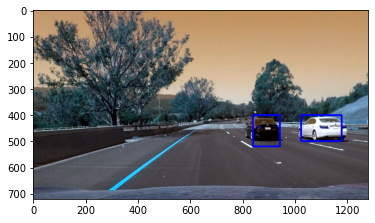

In [323]:
plt.imshow(draw_img)

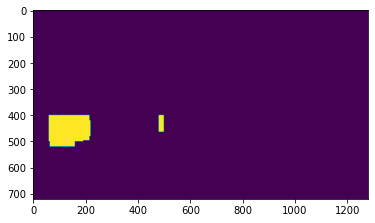

In [295]:
plt.imshow(hot_map)

In [251]:
hot_map.max()

0.0

In [210]:
hot_map

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
dump(clf, 'model.joblib')

In [131]:
def pipeline(img, clf, y_start, overlap):
        boxes = get_windows(img,y_start,overlap)
        vehicles_boxes =  boxes_filter(boxes, clf)
        hot_map = voting(vehicles_boxes, img.shape, y_start)
        labels = label(hot_map)
        draw_img = draw_labeled_bboxes(np.copy(img), labels)
        return draw_img

In [ ]:
clip = cv2.VideoCapture(input_vid_dic)
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter(output_vid_dic+'\output_vid.mp4',fourcc, 25,(int(clip.get(3)),int(clip.get(4))))
frame_count = int(clip.get(cv2.CAP_PROP_FRAME_COUNT))
pbar = tqdm.tqdm(total = frame_count)

i = 1
while clip.isOpened():
    flag,frame  = clip.read()
    pbar.update()
    i = i+1
    if not flag:
        break
    if i == 500:
        break
    processed_frame = pipeline(frame,clf,y_start,overlap)
    out.write(processed_frame)
    
    
    
out.release()
clip.release()
cv2.destroyAllWindows()



 23%|█████████████████▊                                                           | 291/1260 [39:00<2:08:26,  7.95s/it]